In [14]:
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 6.1 MB/s eta 0:00:00


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import missingno as msno
import warnings
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Cargar el dataset
df = pd.read_csv('Titanic-Dataset.csv')

# Crear variables derivadas para análisis adicional
df['Family_Size'] = df['SibSp'] + df['Parch'] + 1
df['Is_Alone'] = (df['Family_Size'] == 1).astype(int)
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100],
                         labels=['Niño', 'Adolescente', 'Adulto Joven', 'Adulto', 'Mayor'])

In [50]:
# Tablas de valores faltantes
# Porcentaje de valores faltantes por clase de supervivencia
missing_by_survived = (
    df.drop(columns=["Survived"])
      .groupby(df["Survived"])
      .apply(lambda x: x.isna().mean() * 100)
)
print("Porcentaje de valores faltantes por clase de supervivencia:")
display(missing_by_survived.round(2))

# Porcentaje de valores faltantes por clase del ticket
missing_by_pclass = (
    df.drop(columns=["Pclass"])
      .groupby(df["Pclass"])
      .apply(lambda x: x.isna().mean() * 100)
)
print("\nPorcentaje de valores faltantes por clase:")
display(missing_by_pclass.round(2))

# Porcentaje de valores faltantes por género
missing_by_sex = (
    df.drop(columns=["Sex"])
      .groupby(df["Sex"])
      .apply(lambda x: x.isna().mean() * 100)
)
print("\nPorcentaje de valores faltantes por género:")
display(missing_by_sex.round(2))

# Distribución de pasajeros por clase y género
dist_class_gender = pd.crosstab(df['Pclass'], df['Sex'])
print("\nDistribución de pasajeros por clase y género:")
display(dist_class_gender)

# Estadísticas de edad por clase y género
age_stats = df.groupby(['Pclass','Sex'])['Age'].describe()
print("\nEstadísticas de edad por clase y género:")
display(age_stats.round(2))


# Fairness Metrics
# Paridad demográfica por género
survival_rate_by_gender = df.groupby('Sex')['Survived'].mean() * 100
print("\nParidad demográfica (tasa de supervivencia) por género:")
display(survival_rate_by_gender.round(2))

# Paridad demográfica por clase
survival_rate_by_class = df.groupby('Pclass')['Survived'].mean() * 100
print("\nParidad demográfica (tasa de supervivencia) por clase:")
display(survival_rate_by_class.round(2))

# Preparación de datos
# Suponemos que ya tienes el DataFrame df cargado
# Convertimos sexo a numérico para fairness metrics
df['Sex_num'] = df['Sex'].map({'male': 1, 'female': 0})

X = df[['Pclass', 'Age', 'Sex_num', 'Is_Alone']]
y = df['Survived'].astype(int)

# Eliminamos filas con NaN en variables relevantes
X = X.dropna()
y = y.loc[X.index]

# Entrenar un modelo simple para calcular fairness metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Métricas de equidad
dp_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test['Sex_num'])
eo_ratio = equalized_odds_ratio(y_test, y_pred, sensitive_features=X_test['Sex_num'])

print(f"Demographic Parity Ratio (por género): {dp_ratio:.3f}")
print(f"Equalized Odds Ratio (por género): {eo_ratio:.3f}")

print("\n=== 4.3 Fairness Metrics ===")
print("\n- Paridad demográfica por género y clase:")
print(df.groupby('Sex')['Survived'].mean().round(2))
print(df.groupby('Pclass')['Survived'].mean().round(2))

# Igualdad de oportunidad con matriz de confusión
cm = confusion_matrix(y_test, y_pred)
tp_rate = cm[1,1]/(cm[1,1]+cm[1,0])
fn_rate = cm[1,0]/(cm[1,1]+cm[1,0])
print(f"\n- Igualdad de oportunidad (TPR): {tp_rate:.3f}, (FNR): {fn_rate:.3f}")

print(f"\n- Odds equalizados: {eo_ratio:.3f}")

Porcentaje de valores faltantes por clase de supervivencia:


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Is_Alone,Age_Group
Survived,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,22.77,0.0,0.0,0.0,0.0,87.61,0.00,0.0,0.0,22.77
1,0.0,0.0,0.0,0.0,15.20,0.0,0.0,0.0,0.0,60.23,0.58,0.0,0.0,15.20



Porcentaje de valores faltantes por clase:


,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Is_Alone,Age_Group
Pclass,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,13.89,0.0,0.0,0.0,0.0,18.52,0.93,0.0,0.0,13.89
2,0.0,0.0,0.0,0.0,5.98,0.0,0.0,0.0,0.0,91.30,0.00,0.0,0.0,5.98
3,0.0,0.0,0.0,0.0,27.70,0.0,0.0,0.0,0.0,97.56,0.00,0.0,0.0,27.70



Porcentaje de valores faltantes por género:


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Is_Alone,Age_Group
Sex,,,,,,,,,,,,,,
female,0.0,0.0,0.0,0.0,16.88,0.0,0.0,0.0,0.0,69.11,0.64,0.0,0.0,16.88
male,0.0,0.0,0.0,0.0,21.49,0.0,0.0,0.0,0.0,81.46,0.00,0.0,0.0,21.49



Distribución de pasajeros por clase y género:


Sex,female,male
Pclass,,
1,94,122
2,76,108
3,144,347



Estadísticas de edad por clase y género:


count   mean    std   min    25%   50%    75%   max
Pclass Sex                                                        
1      female   85.0  34.61  13.61  2.00  23.00  35.0  44.00  63.0
       male    101.0  41.28  15.14  0.92  30.00  40.0  51.00  80.0
2      female   74.0  28.72  12.87  2.00  22.25  28.0  36.00  57.0
       male     99.0  30.74  14.79  0.67  23.00  30.0  36.75  70.0
3      female  102.0  21.75  12.73  0.75  14.12  21.5  29.75  63.0
       male    253.0  26.51  12.16  0.42  20.00  25.0  33.00  74.0


Paridad demográfica (tasa de supervivencia) por género:


,Survived
Sex,
female,74.20
male,18.89



Paridad demográfica (tasa de supervivencia) por clase:


,Survived
Pclass,
1,62.96
2,47.28
3,24.24


Demographic Parity Ratio (por género): 0.136
Equalized Odds Ratio (por género): 0.124

=== 4.3 Fairness Metrics ===

- Paridad demográfica por género y clase:
Sex
female    0.74
male      0.19
Name: Survived, dtype: float64
Pclass
1    0.63
2    0.47
3    0.24
Name: Survived, dtype: float64

- Igualdad de oportunidad (TPR): 0.652, (FNR): 0.348

- Odds equalizados: 0.124


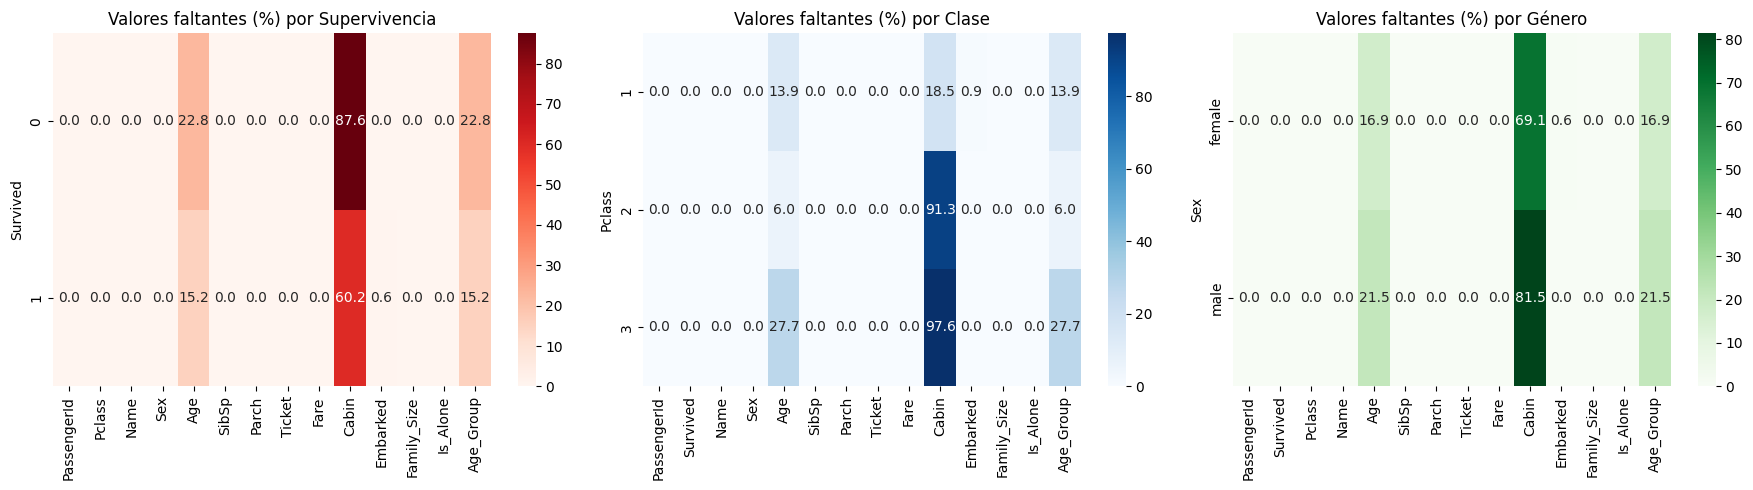

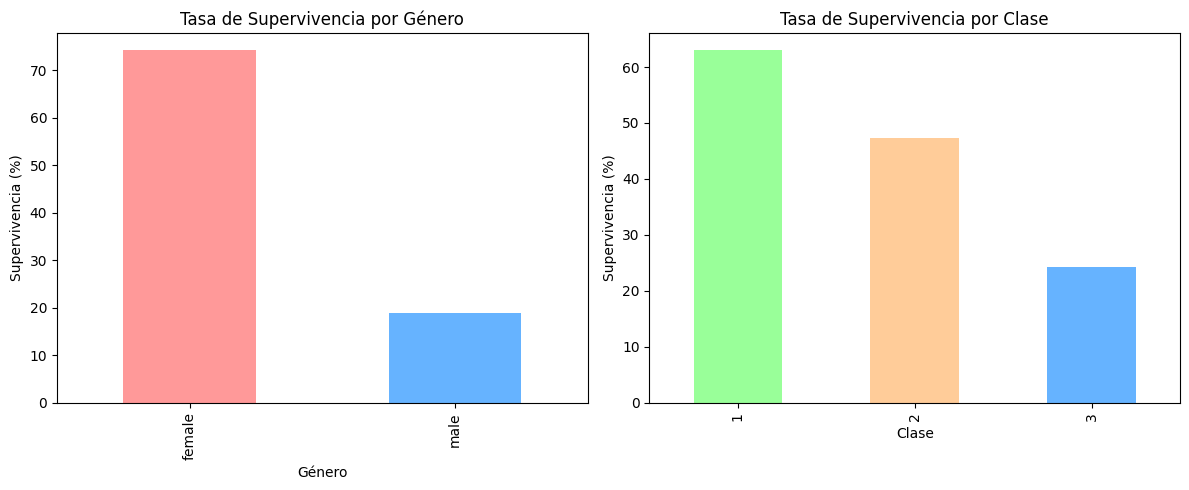

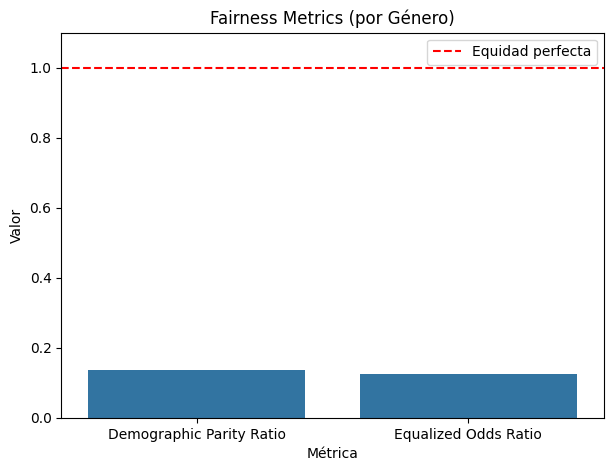

In [51]:
# Heatmap de valores faltantes por clase de supervivencia, clase y género
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(missing_by_survived, annot=True, cmap="Reds", fmt=".1f", ax=axes[0])
axes[0].set_title("Valores faltantes (%) por Supervivencia")

sns.heatmap(missing_by_pclass, annot=True, cmap="Blues", fmt=".1f", ax=axes[1])
axes[1].set_title("Valores faltantes (%) por Clase")

sns.heatmap(missing_by_sex, annot=True, cmap="Greens", fmt=".1f", ax=axes[2])
axes[2].set_title("Valores faltantes (%) por Género")

plt.tight_layout()
plt.show()


# Barras comparativas de supervivencia por género y clase
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

survival_rate_by_gender.plot(kind="bar", color=["#ff9999","#66b3ff"], ax=axes[0])
axes[0].set_title("Tasa de Supervivencia por Género")
axes[0].set_ylabel("Supervivencia (%)")
axes[0].set_xlabel("Género")

survival_rate_by_class.plot(kind="bar", color=["#99ff99","#ffcc99","#66b3ff"], ax=axes[1])
axes[1].set_title("Tasa de Supervivencia por Clase")
axes[1].set_ylabel("Supervivencia (%)")
axes[1].set_xlabel("Clase")

plt.tight_layout()
plt.show()

# Visualización de fairness metrics
fairness_df = pd.DataFrame({
    "Métrica": ["Demographic Parity Ratio", "Equalized Odds Ratio"],
    "Valor": [dp_ratio, eo_ratio]
})

plt.figure(figsize=(7, 5))
sns.barplot(data=fairness_df, x="Métrica", y="Valor")
plt.axhline(1.0, color="red", linestyle="--", label="Equidad perfecta")
plt.title("Fairness Metrics (por Género)")
plt.ylim(0, 1.1)
plt.legend()